# ARTIFIVE-POTSDAM DEMO

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from pathlib import Path

import torch as th
import torchvision as tv

from imagedataset import ImageDataset, collate_fn
from open_turbo_jpeg import open_turbo_jpeg
from transformations import Resize, StandardNormalize, Compose, denormalize
import shapely

import matplotlib.pyplot as plt

from visualization import draw_rectangles, draw_texts

# dataset paths

* adjust accordingly

In [3]:
potsdam_training_path = Path("/fastdata/artifive-potsdam/v1/patched/600x600_overlap200/training/")
potsdam_test_path = Path("/fastdata/artifive-potsdam/v1/patched/600x600/test/")
sample_filename = "annotations*.json"

In [4]:
art_path = Path("/fastdata/artifive-potsdam/v1/artificial/")

# prepare dataset

## sample preprocessor

can modify samples when creating dataset

In [5]:
min_size = 20
max_size = 200
min_either_size = 40 # at least one side needs to be larger

def sample_preprocessor(sample):
    # this removes polygons whose sizes are outside of the specified limits
    # it is applied as a preprocessing step
    polys = sample["annotations"]["polygons"] 
    if len(polys):
        polys_tensored = th.tensor([p.bounds for p in polys])
        sizes = polys_tensored[:,2:] - polys_tensored[:, :2]
        keeper = ((sizes > min_size) & (sizes < max_size)).all(-1)
        keeper = keeper & (sizes > min_either_size).any(-1)
        for k, vs in sample["annotations"].items():
            sample["annotations"][k] = [v for v, keep in zip(vs, keeper) if keep]
    return sample

## sample pre filters

can remove samples when creating dataset; is called after sample preprocessor

In [6]:
def remove_empty(sample):
    return len(sample["annotations"]["labels"]) > 0

def remove_nonempty(sample):
    return len(sample["annotations"]["labels"]) == 0

## polygon to axis aligned bounding box transformation

* since the annotations contain object polygons they need to be converted to suitable format
* here we convert these shapely polygons to axis aligned bounding boxes
* it is called in the transformation pipeline
* a similar function needs to be designed if one wants to use object aligned bounding boxes

In [7]:
def __clip_polys(polys, image_size):
    box = shapely.geometry.box(0, 0, image_size[2] - 1, image_size[1] - 1)
    return [p.intersection(box) for p in polys]

def __remove_objects(objects, drop_list):
    for key, values in objects.items():
        objects[key] = [v for v, drop in zip(values, drop_list) if not drop]
    return objects
    
def polys_to_axisaligned_boxes(input, target):
    if "polygons" in target:
        target = target.copy()
        target["polygons"] = __clip_polys(target["polygons"], input["image"].shape)
        drop_list = [p.is_empty for p in target["polygons"]]
        target = __remove_objects(target, drop_list) 
        polygons = target.pop("polygons")
        boxes = [p.bounds for p in polygons]
        target["boxes"] = boxes
    return input, target

## prepare transformation pipeline

* downsampling to maximal 300 x 300 pixel
* the collate function pads batch samples if needed
* image normalization to ImageNet stats
* polygon to bounding box conversion

In [8]:
data_stats_imagenet = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_mean = data_stats_imagenet[0]
data_std = data_stats_imagenet[1]

transforms = Compose([
    Resize(300, max_size=300),
    StandardNormalize(data_mean, data_std),
    polys_to_axisaligned_boxes, 
])

## create dataset and dataloader

* here we use a libjpeg-turbo accelerated image loading function
* optional segmentations are provided for the Potsdam part of the dataset, but not for the artificial part
* for fusion of real and artificial images resort to pytorchs utilities like torch.utils.data.ConcatDataset()

In [9]:
dataset = ImageDataset(
    potsdam_training_path, 
    sample_filename=sample_filename, 
    transform=transforms,
    sample_preprocessor=sample_preprocessor,
    sample_filter=remove_empty,
    add_segmentation=False,
    image_loading_fn=open_turbo_jpeg,
)

batch_size = 32
num_workers = 8
shuffle = True
dataloader = th.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn, shuffle=shuffle)

len(dataset), len(dataloader)

(2922, 92)

In [10]:
dataset.get_sample_info()

{'n_samples': 2922, 'n_empty_samples': 0}

In [11]:
dataset.get_target_info()

OrderedDict([('car', 12599), ('n_targets', 12599)])

# single sample

(dict_keys(['image', 'mask', 'image_size', 'image_id', 'image_filename']),
 dict_keys(['labels', 'is_difficult', 'boxes', 'image_id']))

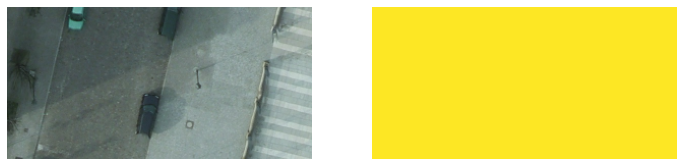

In [12]:
input, target = dataset[-1]
image = denormalize(input["image"], data_mean, data_std)

f, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(image.permute(1, 2, 0).clip(0, 1))
c = axs[1].imshow(input["mask"].permute(1, 2, 0))
c.set_clim(0, 1)
for ax in axs:
    ax.axis(False)

input.keys(), target.keys()

# single batch

In [13]:
# this is used for plotting
inverse_label_map = {v: k for k, v in dataset.label_map.items()}
inverse_label_map

{0: 'car'}

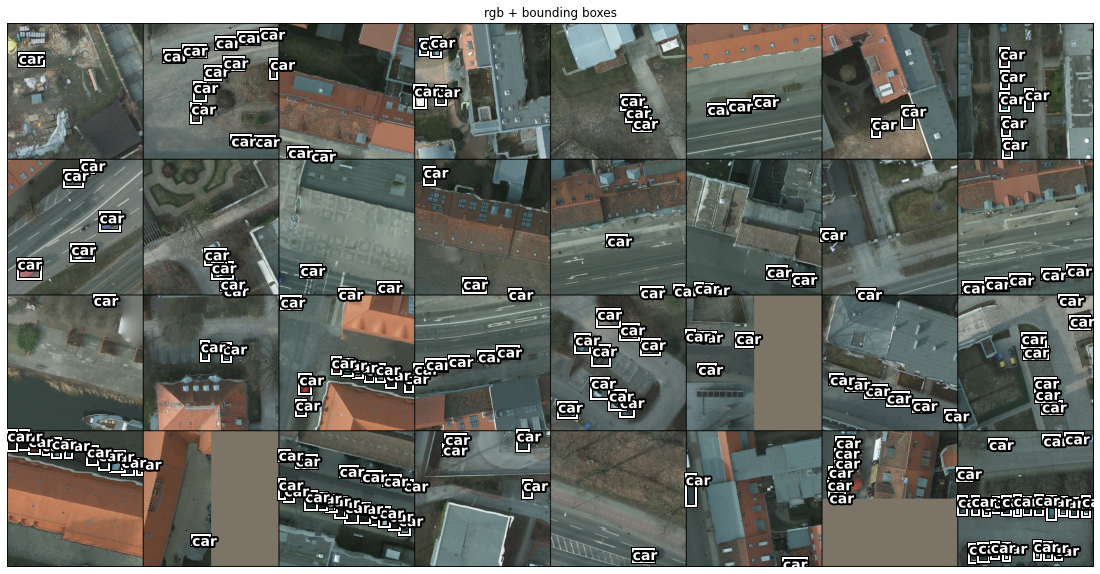

In [14]:
input, target = next(iter(dataloader))
images = input["image"]
images = denormalize(images, data_mean, data_std)

n_cols = 8
padding = 2

gridded_images = tv.utils.make_grid(images, n_cols, padding)
gridded_masks = tv.utils.make_grid(input["mask"], n_cols, padding)

f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(gridded_images.permute(1, 2, 0))
ax.axis(False);
ax.set_title("rgb + bounding boxes");

_, h, w = images[0].shape
j = -1
for i, (bxs, lbls) in enumerate(zip(target["boxes"], target["labels"])):
    bxs = bxs.clone()
    bxs[:,::2] = bxs[:,::2] + (w + padding) * (i % n_cols)
    if i % n_cols == 0:
        j += 1
    bxs[:,1::2] = bxs[:,1::2] + (h + padding) * j
    draw_rectangles(ax, bxs)
    lbls = [inverse_label_map[lb] for lb in lbls.tolist()]
    draw_texts(ax, lbls, bxs[:,:2])

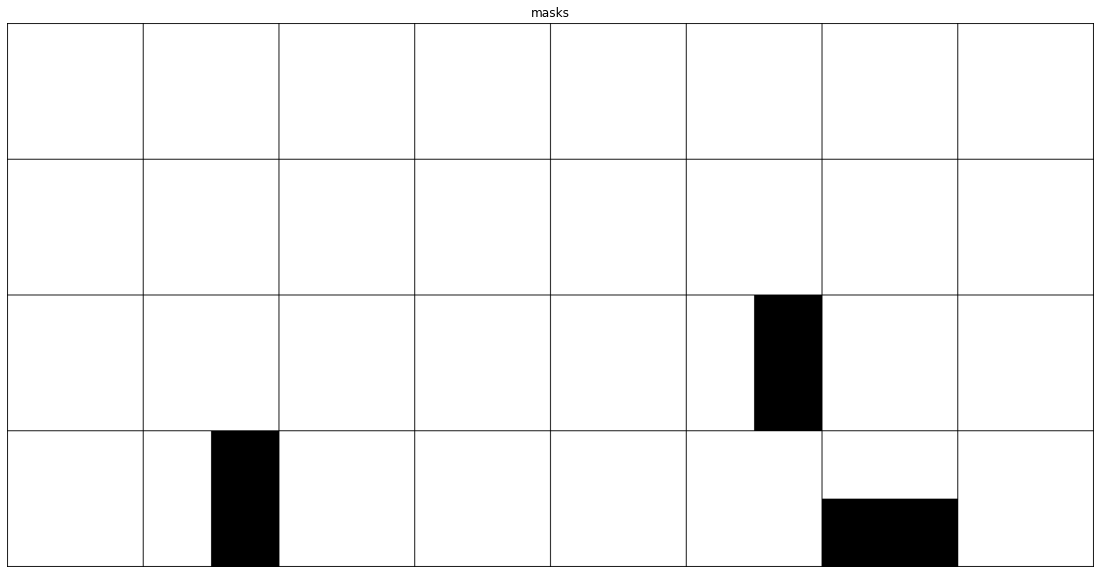

In [15]:
f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(gridded_masks.permute(1, 2, 0))
ax.axis(False);
ax.set_title("masks");